<a href="https://colab.research.google.com/github/sofials2002/SOFIA/blob/master/Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Selection Bias in Observational Data

Imagine we want to study the effect of a new recommendation algorithm on user engagement, which increases user engagement by 10% on average.

Consider two data scientists:

1. **Bad Data Scientist**: Rolls out the algorithm to everyone in a market and measures the effect. Users can opt in to the algorithm, and this opt-in behavior is associated with higher user engagement (e.g., heavy users are eager to try the new algorithm to the old one).

2. **Good Data Scientist**: Rolls out the algorithm to a random 50% of the users in this market and measures the effect.

The potential outcomes can be described as:

$$
Y(1) = Y(0) + \delta, \quad \delta \sim \text{Normal}(0.1, 1)
$$

where $Y(1)$ is the *potential* time spent with the **new** algorithm, $Y(0)$ is the *potential* time spent with the **old** algorithm, and $\delta$ is the effect.

The action of opting in to the algorithm is denoted by $D$, which is not assigned in an experimental study. The chosen "treatment" variable $D$ is potentially positively associated with the user engagement outcome, inducing selection bias - the difference between the predictive effect and the causal effect.

Why does this happen? If users that opt in are more likely to be heavy users (experts on your platform), then the effect of the algorithm will be overestimated.

In contrast, the good data scientist uses a randomized controlled trial (RCT) to measure the effect of the algorithm, assigning the treatment $T$ randomly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

%config InlineBackend.figure_format = "retina"

In [2]:
# Multivariate normal distribution of three variables with mean 0 and covariance sigma
sigma = np.array([[1, 0.5, 0.25],
                  [0.5, 1, 0.25],
                  [0.25, 0.25, 1]])
mu = np.array([0, 0, 0]) #mean of each one.
n = 100000
delta = np.random.normal(0.1, 1, n)
E = np.random.multivariate_normal(mu, sigma, n) #creating a matrix that comes from a multivariate normal distribution.
e0 = E[:, 0] #first vector
e1 = E[:, 1] #second vector
v = E[:, 2] #third vector

# Individuals choose treatment based on unobserved variable v
D = (v > 0) * 1 #v greater than zero, meaning that the likelihood is high. Dummy outcome.

# Randomized individuals using binomial distribution
T = np.random.binomial(1, 0.5, n)

# Potential outcomes
y0 = e0
y1 = e1 + delta #i.e, potential time spent on instagram.

In [3]:
# Observed outcomes with observational data
yD = D*y1 + (1-D)*y0
# Observed outcomes with randomized data
yT = T*y1 + (1-T)*y0

print('SDO:', (yD[D == 1].mean() - yD[D == 0].mean()).round(3)) #simple difference of outcomes
print('ATE:', (yT[T == 1].mean() - yT[T == 0].mean()).round(3))

SDO: 0.514
ATE: 0.099


Let's do this 10K times and compare the results

In [4]:
# create a multivariate normal distribution of three variables with mean 0 and covariance sigma
nsample = 1000
nsim = 10000
ate = []
sdo = []

for i in range(nsim):
    delta = np.random.normal(0.1, 1, nsample)
    E = np.random.multivariate_normal(mu, sigma, nsample)
    e0 = E[:, 0]
    e1 = E[:, 1]
    v = E[:, 2]
    D = (v > 0) * 1
    T = np.random.binomial(1, 0.5, nsample)
    y0 = e0
    y1 = e1 + delta
    yD = D*y1 + (1-D)*y0
    yT = T*y1 + (1-T)*y0
    sdo.append(yD[D == 1].mean() - yD[D == 0].mean())
    ate.append(yT[T == 1].mean() - yT[T == 0].mean())

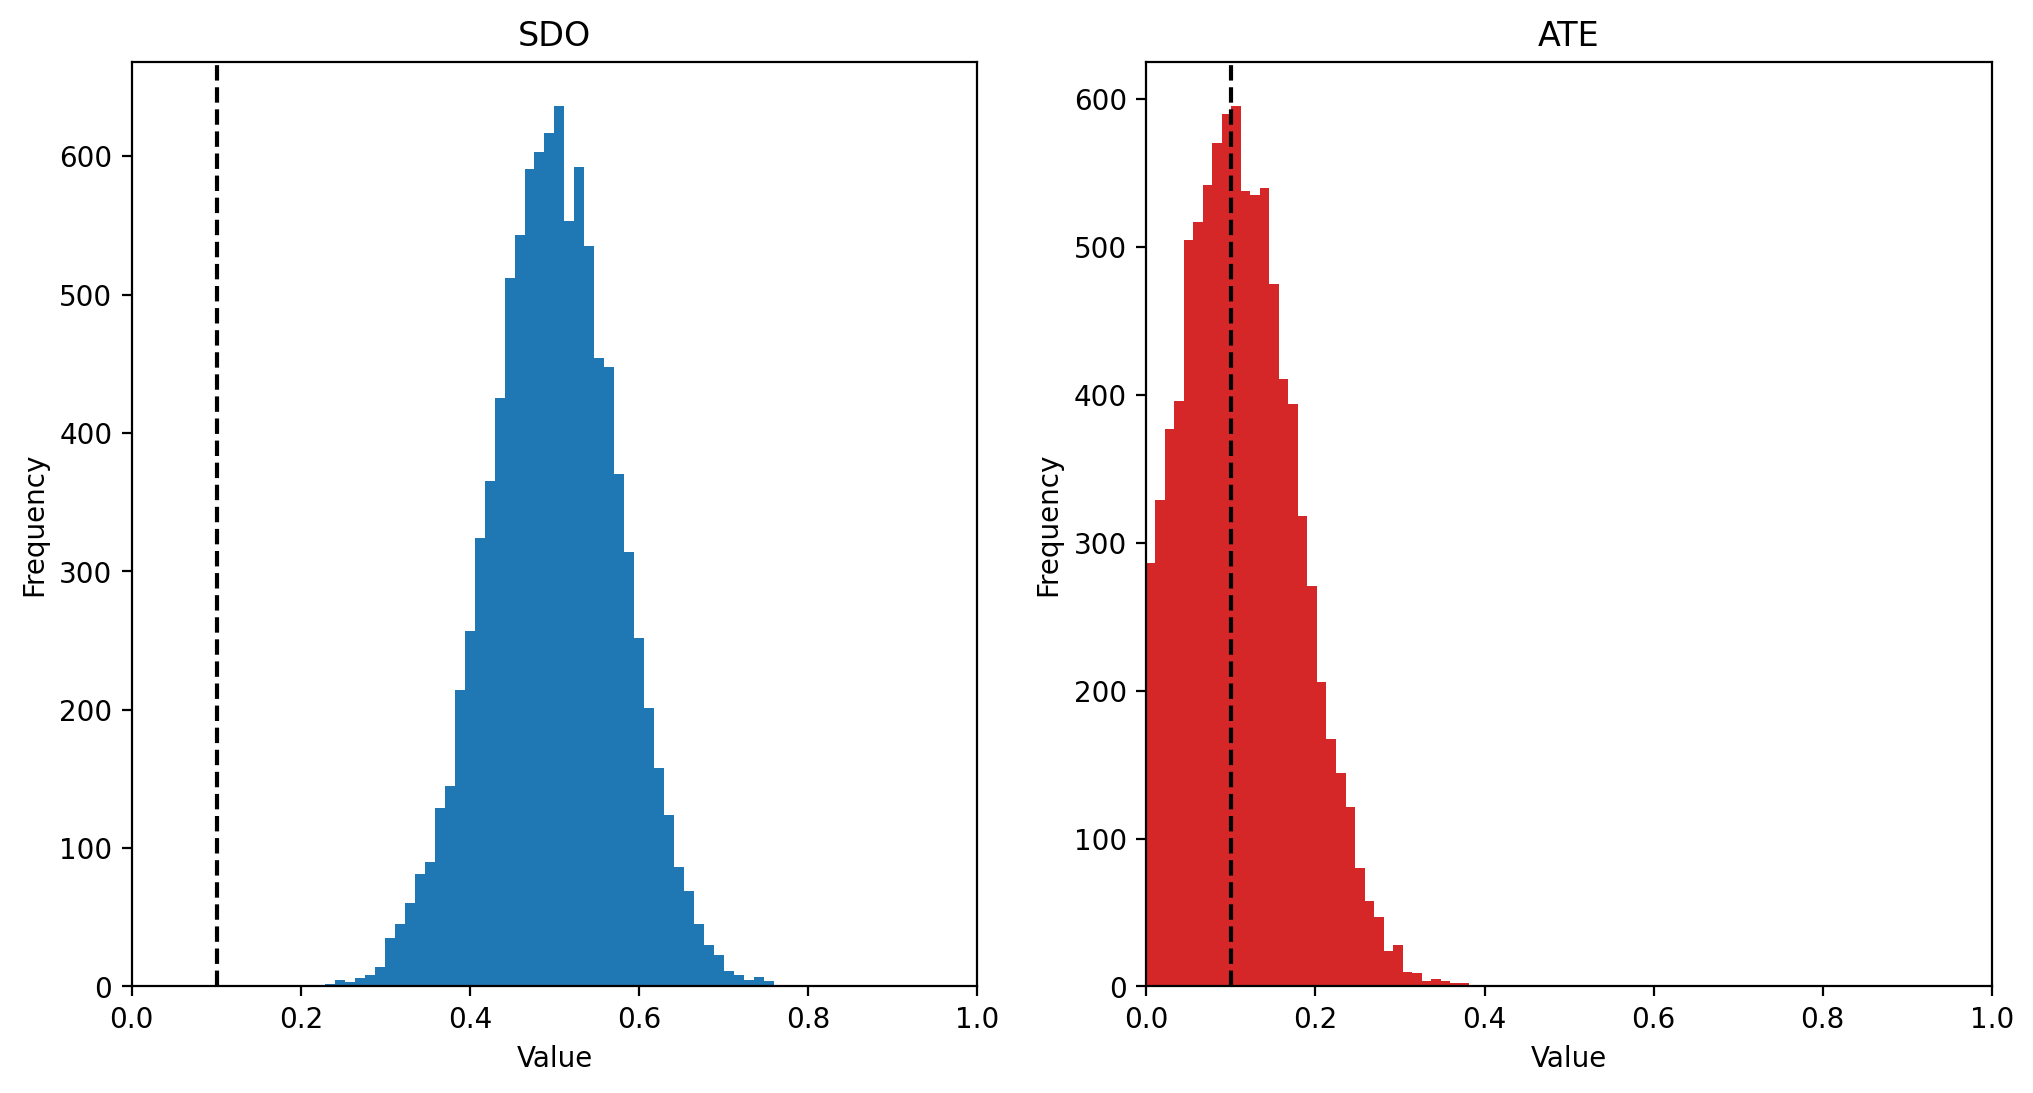

In [5]:
# Plot the distribution of the SDO and ATE

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist(sdo, bins=50, color='tab:blue')
ax[0].axvline(np.mean(ate), color='black', linestyle='--')
ax[0].set_title('SDO')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[0].set_xlim(0, 1)

ax[1].hist(ate, bins=50, color='tab:red')
ax[1].axvline(np.mean(ate), color='black', linestyle='--')
ax[1].set_title('ATE')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(0, 1)

plt.show()